# Simon's algorithm in pyQuil

![TeamName](https://media.giphy.com/media/5wFjITVDtKD0wwJe7V/source.gif "pied pipper")

In [134]:
import numpy as np
import itertools
import time
import matplotlib.pyplot as plt

from pyquil import Program, get_qc
from pyquil.gates import *
from pyquil.quil import DefGate
from grove.simon.simon import create_valid_2to1_bitmap, create_1to1_bitmap
from sympy import *
from collections import defaultdict, Counter

In [135]:
def create_Uf(f, n):
    """
    Creats Uf matrix needed in simons algorithm
    
    @param f: Input function that we want to encode
    @param n: Number of qubits. 2*(len(input to f))
    
    @return: Numpy matrix Uf
    """
    dim = 2**n
    # creating a 2^n x 2^n zeros matrix. 
    Uf = np.zeros((dim, dim), dtype=int)
    # This creates a list of the different permutations of n bits. 
    lst_bitseq = list(map(list, itertools.product([0, 1], repeat=n)))
    for col, bitseq in enumerate(lst_bitseq):
        # applying the operation on the last helper bit. 
        last_bits = [x^y for x,y in zip(bitseq[int(n/2):], f(bitseq[:int(n/2)]))] # b+f(x)
        final_bitseq = [bit for bit in bitseq[:int(n/2)]] + [bit for bit in last_bits]
        # using the To-Form method discussed in class to help create the Uf matrix. 
        Uf[lst_bitseq.index(final_bitseq), col] = 1
    return Uf

In [136]:
def create_simon_circuit(f, n):
    """
    This function will create the program.
    
    @param f: Input function that we want to encode
    @param n: Number of qubits. 2*len(input to f)
    
    @return: Pyquil Program
    """
    uf = create_Uf(f, n)
    uf_definition = DefGate("UF", uf)
    UF = uf_definition.get_constructor()
    
    p = Program()
    p += uf_definition
    for i in range(int(n/2)):
        p += H(i)
    p += Program("UF {}".format(' '.join(str(x) for x in list(range(0, n)))))
    for i in range(int(n/2)):
        p += H(i)
    return p

In [137]:
def build_matrix(res,n):
    """
    Given the result from circuit it build a matrix of the equations
    
    @param res: result received from run_and_measure
    @param n: length of input to f
    
    @return: Matrix with each row as y_i
    """
    A = []
    for j in range(n-1):
        curr = []
        for i in range(n):
            curr.append(res[i][j])
        A.append(curr)

    return Matrix(A)

In [138]:
def run_circuit(f, n, m):
    """
    creates and runs a circuit
    
    @param f: Input function that we want to encode
    @param n: (len(input to f))
    @param m: m decides the number of times we run the loop. Higher m means
                higher probablity of finding s.
    
    @return: result
    """
    p = create_simon_circuit(f, 2*n)
    qc = get_qc('{}q-qvm'.format(2*n))
    qc.compiler.client.timeout = 600
    found = False
#     prob = defaultdict(int)
    B = []
    for i in range(4*m):
        result = qc.run_and_measure(p, trials=n-1)
        A = build_matrix(result, n)

        for j in range(n-1):
            curr = []
            for i in range(n):
                curr.append(int(result[i][j]))
            B.append(curr)

        if A.rref()[0].row(-1) == Matrix([[0]*n]):
            # we have linearly dependent equations
            continue
        else:
            # we have found linearly independent equations so solve and end
            out = [abs(x[0]) for x in A.nullspace()[0].tolist()]
            if f([0]*n) == f(out):
                print("We have found s={} on iteration number {}".format(''.join([str(x) for x in out]),i+1))
                found = True
                break
        
    if not found:
        c = Counter(B)
        print(c)
            
    
    print("After running n-1 trials 4*m times with m={} we have \
          not found a set of linearly independent equations".format(m))
    return

In [139]:
def get_func_2to1(s):
    """
    This function can be used to build a test case for given s
    Note that this function doesn't do any validity checks so make sure you give correct s
    
    @param s: input s
    
    @return: 2 to 1 function that takes x and returns mapping based on s
    """
    def func(x):
        mapping = create_valid_2to1_bitmap(mask=s,random_seed=42)
        return [int(i) for i in list(mapping[''.join(str(a) for a in x)])]
    return func

In [140]:
def get_func_1to1(s):
    """
    This function can be used to build a test case for given s
    Note that this function doesn't do any validity checks so make sure you give correct s
    
    @param s: input s
    
    @return: 1 to 1 function that takes x and returns mapping based on s
    """
    def func(x):
        mapping = create_1to1_bitmap(mask=s)
        return [int(i) for i in list(mapping[''.join(str(a) for a in x)])]
    return func

### First show that it works for 1to1 mapping.

In [141]:
run_circuit(get_func_1to1('11'),2,10)

TypeError: unhashable type: 'list'

# Verify correctness for 2to1 and check if we see different functions give different execution times?

We think it doesn't make sense for testing how long it takes for simons problem as getting n-1 linearly independent solutions is completely based on chance. Anyways below we have the graph for comparing the 4 cases when n=4. (Only looking at 2to1 mapping functions)

In [30]:
time_it_took = []
lst_bitseq = ['10','11']

for i in range(len(lst_bitseq)):
    start = time.time()
    run_circuit(get_func_2to1(lst_bitseq[i]), 2,10)
    end = time.time()
    time_it_took.append(end-start)

We have found s=10 on iteration number 10
We have found s=11 on iteration number 3


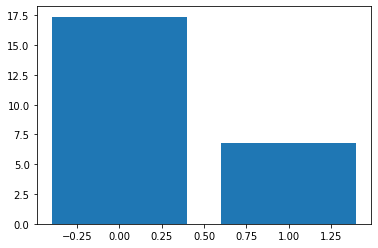

In [31]:
%matplotlib inline
plt.bar(np.arange(2), time_it_took)
plt.show()

# Here we plot the runtime as n increases

We were not able to run simons algorithm for n=4 in a realistic amount of time and it doens't make sense to run with n=1. So only plotting the result for n=2 and n=3. Anyways this will also face the same issue of taking variable amount of time because it is non-deterministic

In [32]:
time_it_took = []
lst_bitseq = ['11']

for i in range(1):
    start = time.time()
    run_circuit(get_func_2to1(lst_bitseq[i]), i+2,10)
    end = time.time()
    time_it_took.append(end-start)

We have found s=11 on iteration number 9


# How to use our code?

Running this is straightforward. We have a function called run_circuit which takes 3 arguments. The first argument is the function that we are using. This function can be easily built using get_func_2to1 or get_func_1to1 by passing an s value. 2nd argument is length of the input to this function. 3rd argument is m which controlls the number of trials. Higher value of m implies higher chance of finding s. For given m we can say that the probablity of not finding s is lower than e^-m. This is why in our experiments we have used m=10